In [1]:
import torch

In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.7


# *Задание по NLP №1*
# *Задача*
По данным из соревнования: https://www.kaggle.com/competitions/nlp-txt-classification/data 
(https://www.kaggle.com/t/9bb00c50204b4413ac229e3165837dac)
1) Сделайте EDA. 
2) Придумайте эвристику для предсказания целевого класса. На данном этапе нельзя использовать ML, допускаются исключительно наивные методы. 
3) Реализуйте один из методов векторизации текста и обучите одну из моделей классического ML для данной задачи. Можно использовать любые библиотеки. 
4) Предложите метрику, разбейте обучающую выборку на обучающую и валидационную и посчитайте её значение для методов, реализованных в пункте 2 и 3. 

# *Результат:*
Jupyter-notebook с анализом данных и реализацией требуемых методов.

Оцениваться эта часть итогового проекта будет по трём критериям:

1. Полнота выполненной работы; 
2. Общее качество кода и следование PEP-8; 
3. Итоговое значение метрики качества. 

# *Подсказки:*
a) EDA – это не только ячейки с кодом и выводом интерпретатора, но и текст с вашими выводами касательно данных. 

b) Не забудьте реализовать нормализацию текстов. 

c) Во 2 задании не ограничивайте себя – посмотрите на примеры, подумайте на что именно вы обращаете внимание при определении тональности текста своим мозгом. Из текста можно извлечь множество признаков! 

# *Критерии оценки результата:*
**Критерий 1. Полнота выполненной работы**
Вариант 1	Реализован EDA с выводами на основе данных, реализованы задачи 2 и 3, посчитана метрика для этих задач.	-- 25 баллов 

Вариант 2	Реализован EDA, но при этом нет выводов от студента, реализованы задачи 2, 3, посчитана метрика для этих задач. -- 18 баллов 

Вариант 3	Реализован EDA, но при этом нет выводов от студента, реализованы задачи 2, 3, при этом не посчитана метрика.	-- 10 баллов 

Вариант 4	Отсутствует EDA или задачи 2 и 3. --4 балла

______________________________________________________________________________________
**Критерий 2. Общее качество кода и следование PEP-8**
Вариант 1	Понятная структура ноутбука, код соответствует PEP-8 и логически разделён по ячейкам. --25 баллов 

Вариант 2	Понятная структура ноутбука, код местами не соответствует PEP-8, но логически разделён по ячейкам.	-- 18 баллов 

Вариант 3	Понятная структура ноутбука, код сильно не соответствует PEP-8, в одной ячейке могут выполняться разные логические операции. -- 10 баллов 

Вариант 4	Плохая структура, непонятно какая ячейка какую задачу решает, код нечитаем. -- 4 балла
__________________________________________________________________________________________________

In [3]:
# Здесь все необходимые импорты для выполнения этой части ДЗ
import pandas as pd # для работы с датафреймами
import numpy as np # для обработки данных
import matplotlib.pyplot as plt # для графиков и диаграмм
import seaborn as sns # тоже для визуализации
import re # для очистки текста
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from wordcloud import WordCloud # для визуализации наиболее частых слов
from collections import Counter, defaultdict  # для подсчета уникальных элементов и частот слов 
from tqdm import tqdm # для отображения прогресса выполнения

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [4]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset

C:\Users\Nikita INSILICO\anaconda3\envs\alina\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Этап 1: Сделать EDA**

In [5]:
# Загрузка данных
train_data = pd.read_csv('ml-bio-2024/train.csv')
test_data = pd.read_csv('ml-bio-2024/test.csv')

In [6]:
# Ознакомимся с первыми строками данных из train.csv
train_data.head()

,Unnamed: 0,Text,Sentiment
0,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,1,advice Talk to your neighbours family to excha...,Positive
2,2,Coronavirus Australia: Woolworths to give elde...,Positive
3,3,My food stock is not the only one which is emp...,Positive
4,4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
# Проверка на пропущенные значения
print("Проверка на пропущенные значения в данных (train):")
print(train_data.isnull().sum())

Проверка на пропущенные значения в данных (train):
Unnamed: 0    1
Text          1
Sentiment     4
dtype: int64


In [8]:
# Обработка пропущенных значений в классе меток
train_data = train_data.dropna(subset=['Sentiment'])  # Удаляем строки с NaN в метках

In [9]:
# Статистика по классам (Sentiment)
print("Распределение классов в обучающей выборке:")
print(train_data['Sentiment'].value_counts())

Распределение классов в обучающей выборке:
Sentiment
Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64


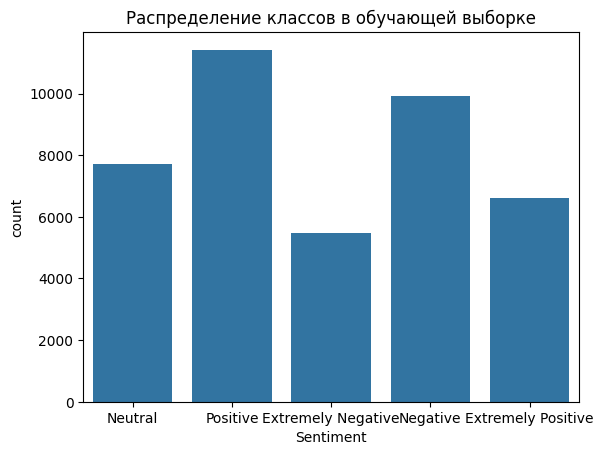

In [10]:
# Визуализация распределения классов
sns.countplot(data=train_data, x='Sentiment')
plt.title('Распределение классов в обучающей выборке')
plt.show()

In [11]:
# Посмотрим уникальные классы в данных
print("Уникальные классы в данных:")
print(train_data['Sentiment'].unique())

Уникальные классы в данных:
['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']


In [12]:
# Функция для очистки текста: удаление ссылок, упоминаний, символов, эмодзи и приведение в нижний регистр
def clean_text(text):
    # Регулярные выражения для различных элементов
    emojis = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]'
    non_ASCII = r'[^\x00-\x7F]+'  # Не-ASCII символы
    mentions = r'@\w+'  # Упоминания
    urls = r'http\S+'  # Ссылки
    punctuation = r'[.,#!$%&\*;:{}=\-_`~()]'  # Знаки пунктуации
    punctuation_space = r'[\\/]'  # Замена специальных символов на пробелы
    whitespace = r'\s+'  # Лишние пробелы

    # Удаление HTML элементов, если они присутствуют
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Удаление не-ASCII символов
    text = re.sub(non_ASCII, ' ', text)
    # Удаление эмодзи
    text = re.sub(emojis, ' ', text)
    # Удаление упоминаний
    text = re.sub(mentions, '', text)
    # Удаление ссылок
    text = re.sub(urls, '', text)
    # Удаление знаков пунктуации
    text = re.sub(punctuation, '', text)
    # Замена символов пунктуации на пробелы
    text = re.sub(punctuation_space, ' ', text)
    # Удаление лишних пробелов
    text = re.sub(whitespace, ' ', text).strip()

    # Приведение текста к нижнему регистру
    text = text.lower()

    return text

In [13]:
# Преобразуем все значения в столбце 'Text' в строки, чтобы избежать ошибки
train_data['Text'] = train_data['Text'].astype(str)

# Теперь можно применить функцию очистки текста
train_data['cleaned_text'] = train_data['Text'].apply(clean_text)

# Просмотр первых строк очищенного текста
print("Первые строки данных после очистки текста:")
print(train_data[['Text', 'cleaned_text']].head())

C:\Users\Nikita INSILICO\AppData\Local\Temp\ipykernel_19808\428468058.py:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
C:\Users\Nikita INSILICO\AppData\Local\Temp\ipykernel_19808\428468058.py:13: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


Первые строки данных после очистки текста:
                                                Text  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   
1  advice Talk to your neighbours family to excha...   
2  Coronavirus Australia: Woolworths to give elde...   
3  My food stock is not the only one which is emp...   
4  Me, ready to go at supermarket during the #COV...   

                                        cleaned_text  
0                                            and and  
1  advice talk to your neighbours family to excha...  
2  coronavirus australia woolworths to give elder...  
3  my food stock is not the only one which is emp...  
4  me ready to go at supermarket during the covid...  


In [14]:
# Количество слов в каждом тексте
train_data['word_count'] = train_data['cleaned_text'].apply(lambda x: len(x.split()))

# Основные статистики по количеству слов
print("Статистика по количеству слов в текстах:")
print(train_data['word_count'].describe())

Статистика по количеству слов в текстах:
count    41155.000000
mean        29.485798
std         11.741181
min          0.000000
25%         20.000000
50%         30.000000
75%         39.000000
max         64.000000
Name: word_count, dtype: float64


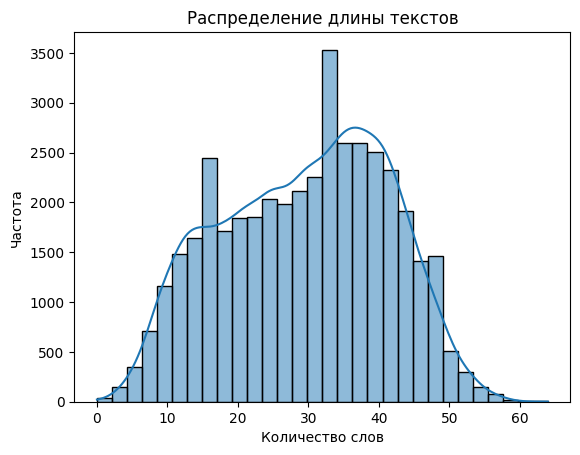

In [15]:
# Визуализация распределения длины текстов
sns.histplot(train_data['word_count'], bins=30, kde=True)
plt.title('Распределение длины текстов')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.show()

In [16]:
# Функция для построения облака слов для каждой категории
def plot_wordcloud(sentiment):
    # Извлечение текстов для данного класса
    text = " ".join(review for review in train_data[train_data['Sentiment'] == sentiment]['cleaned_text'] if review.strip() != "")
    
    # Проверка на наличие текста
    if len(text) == 0:
        print(f"Нет текстов для класса {sentiment}, пропуск генерации облака слов.")
        return
    
    # Генерация облака слов
    wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Облако слов для класса {sentiment}')
    plt.show()

Облако слов для класса Neutral:


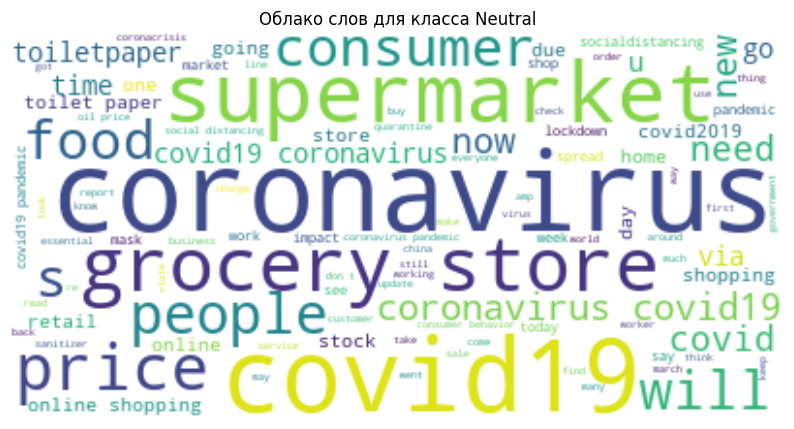

Облако слов для класса Positive:


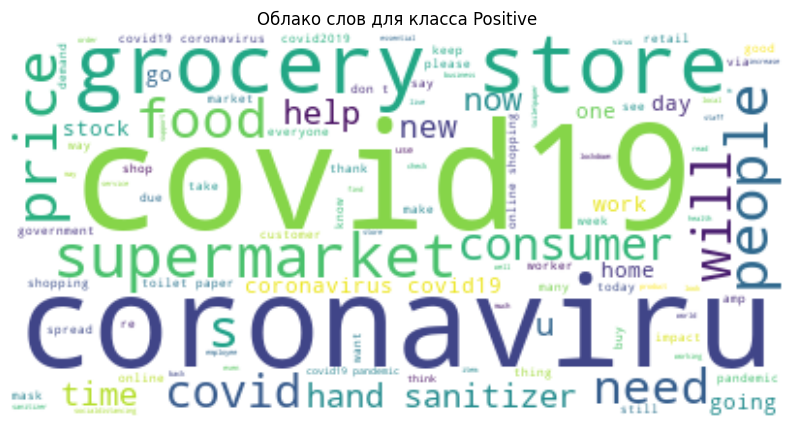

Облако слов для класса Extremely Negative:


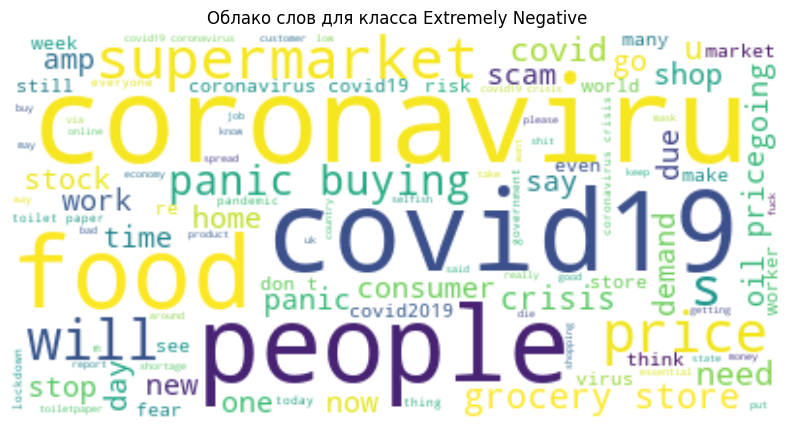

Облако слов для класса Negative:


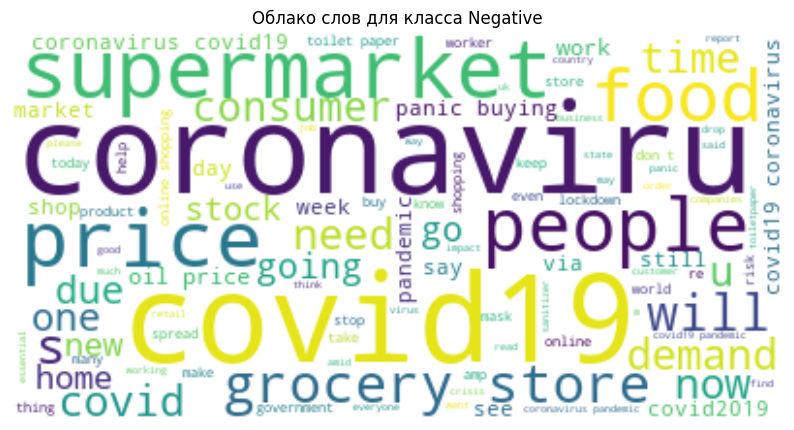

Облако слов для класса Extremely Positive:


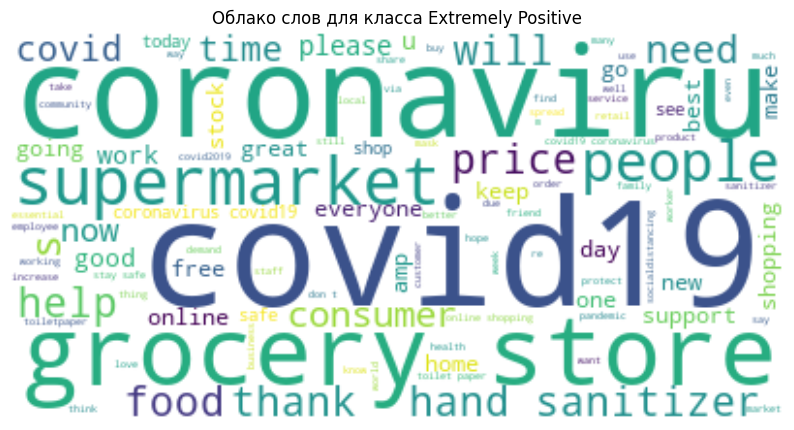

In [17]:
# Облака слов для каждого класса
for sentiment in train_data['Sentiment'].unique():
    print(f"Облако слов для класса {sentiment}:")
    plot_wordcloud(sentiment)

In [18]:
# Функция для получения частот слов для каждого класса
def get_word_frequencies(sentiment):
    words = " ".join(review for review in train_data[train_data['Sentiment'] == sentiment]['cleaned_text']).split()
    return Counter(words)

In [19]:
# Получаем частоты слов для каждого класса
class_frequencies = {}
for sentiment in train_data['Sentiment'].unique():
    if pd.notnull(sentiment):  # Пропускаем nan
        class_frequencies[sentiment] = get_word_frequencies(sentiment)

# Найдем уникальные слова для каждого класса
unique_words = defaultdict(set)
for sentiment, freq in class_frequencies.items():
    other_words = set()
    for other_sentiment, other_freq in class_frequencies.items():
        if other_sentiment != sentiment:
            other_words.update(other_freq.keys())
    unique_words[sentiment] = set(freq.keys()) - other_words

# Просмотр уникальных слов для каждого класса
for sentiment, words in unique_words.items():
    print(f"Уникальные слова для класса {sentiment}:")
    print(words)

Уникальные слова для класса Neutral:
{'gone"', 'blessedbeyondmeasure', 'fortescuemetalsgroup', '27999', 'uploads', 'newrapper', '26273', 'getmeds', 'mktg', '3rw', '"you\'d', 'dakakeena', '6l', 'sunwaypyramid', 'sxtc', 'toiletpapercheap', 'eohed', 'enoug', 'italua', 'mrsshah', 'sbswinners', 'tbilisimetro', 'mian', 'agchatoz', 'covid19germany', '95bn', "f'cough'", 'toppled', 'englandturkey', 'biha?', 'petstore', 'grouos', 'covid2019aus', "pacificcfc's", 'halbiert', 'utwebinar', 'covid16', 'nusret', 'checkups', 'shafauameh', 'coronavirusoutbreak?', 'star?', 'islandwide', 'tomahawkribeye', 'crackdownusacoronavirus', 'noncalifornians', 'dollar??', '"lady', 'epdt', 'bossman', 'coronavirusshopping', 'lager', 'csg', "board's", 'no2', 'ruler???', 'skinnywine', 'washyoass', 'headoffice', 'graphical', 'helen', 'unrealistic"', 'cpb', 'kilburn', 'mathew', 'absolutelynecessary', 'rmc', 'bogotaencasa', 'places???', 'yegvegan', 'spekulant?m', 'heraldtribune]', 'ashleymoody', "???????????'?", 'videos?'

# **Выводы после EDA:**
1. Данные включают пять классов: Neutral, Positive, Extremely Positive, Negative, Extremely Negative.
2. Тексты класса Neutral содержат более общие слова, такие как "covid", "coronavirus", "store", "grocery", что подтверждается визуализацией облаков слов.
3. Тексты класса Extremely Negative содержат слова, указывающие на сильные отрицательные эмоции, такие как "panic", "crisis", "fear".
4. Уникальные слова для каждого класса можно использовать для дальнейшей эвристики и улучшения предсказательной модели.

# **Этап 2: Эвристика для предсказания целевого класса.**
На данном этапе нельзя использовать ML, допускаются исключительно наивные методы.

# **Подход №1: собственная эвристика**

In [18]:
# Используем уникальные слова для каждого класса из этапа 1
extremely_positive_words = list(unique_words['Extremely Positive'])
positive_words = list(unique_words['Positive'])
neutral_words = list(unique_words['Neutral'])
negative_words = list(unique_words['Negative'])
extremely_negative_words = list(unique_words['Extremely Negative'])

In [19]:
# Функция для предсказания класса на основе эвристики
def predict_sentiment(text):
    words = text.lower().split()  # Преобразуем текст в список слов
    
    # Подсчет слов для каждого класса
    ext_pos_count = sum([1 for word in words if word in extremely_positive_words])
    pos_count = sum([1 for word in words if word in positive_words])
    neutral_count = sum([1 for word in words if word in neutral_words])
    neg_count = sum([1 for word in words if word in negative_words])
    ext_neg_count = sum([1 for word in words if word in extremely_negative_words])
    
    # Эвристические правила для предсказания тональности
    if ext_pos_count >= 1:
        return "Extremely Positive"
    elif ext_neg_count >= 1:
        return "Extremely Negative"
    elif pos_count > neg_count:
        return "Positive"
    elif neg_count > pos_count:
        return "Negative"
    else:
        return "Neutral"

In [19]:
# Настраиваем tqdm для работы с pandas
tqdm.pandas()

# Применим эвристику с визуализацией прогресса
train_data['predicted_sentiment'] = train_data['cleaned_text'].progress_apply(predict_sentiment)

# Просмотр первых строк с предсказанными значениями
print("Первые строки с предсказанными значениями:")
print(train_data[['cleaned_text', 'Sentiment', 'predicted_sentiment']].head())

  1%|▋                                                                             | 355/41155 [00:05<11:08, 61.01it/s]


KeyboardInterrupt: 

In [20]:
# Оценим точность эвристической модели
accuracy = (train_data['Sentiment'] == train_data['predicted_sentiment']).mean()
print(f"Точность эвристической модели: {accuracy:.2%}")

print(classification_report(train_data['Sentiment'], train_data['predicted_sentiment']))

Точность эвристической модели: 60.07%
                    precision    recall  f1-score   support

Extremely Negative       1.00      0.50      0.67      5481
Extremely Positive       1.00      0.53      0.69      6624
          Negative       1.00      0.50      0.66      9917
           Neutral       0.32      1.00      0.48      7711
          Positive       1.00      0.51      0.68     11422

          accuracy                           0.60     41155
         macro avg       0.86      0.61      0.64     41155
      weighted avg       0.87      0.60      0.64     41155



In [21]:
# Тексты, предсказанные неверно
incorrect_predictions = train_data[train_data['Sentiment'] != train_data['predicted_sentiment']]
print("Некорректно предсказанные тексты:")
print(incorrect_predictions[['cleaned_text', 'Sentiment', 'predicted_sentiment']])

Некорректно предсказанные тексты:
                                            cleaned_text           Sentiment  \
2      coronavirus australia woolworths to give elder...            Positive   
5      as news of the region s first confirmed covid1...            Positive   
8      due to covid19 our retail store and classroom ...            Positive   
11     due to the covid19 situation we have increased...  Extremely Positive   
13     me i don't need to stock up on food i'll just ...            Positive   
...                                                  ...                 ...   
41147  how exactly are we going to reopen new york ci...            Positive   
41150  uv light sterilizer sanitizer for your mask an...  Extremely Positive   
41151  still shocked by the number of toronto superma...            Negative   
41152  i never that we d be in a situation world that...            Positive   
41153  you are definitely my man i feel like this fal...  Extremely Positive   

     

В принципе, это хороший результат для наивной эвристической модели. В целом он конечно невысок, но это скорее всего из-за того, что классы несбалансированны между собой.

Видно, что модель хорошо распознает (precision) Extremely Negative, Extremely Positive, просто Positive и Negative, но очень плохо Neutral.

Однако, я хочу попробовать еще с обработкой стоп-слов и отрицаний.

In [20]:
# Добавим список отрицаний и стоп-слов для улучшения эвристики
negation_words = ['not', 'no', 'never', 'none', 'nobody', 'nothing', 'neither', 'nor', 'nowhere', 'hardly']
stop_words = ['covid', 'store', 'people', 'grocery', 'coronavirus', 'price', 'consumer', 'supermarket', 'will', 'amp', 'food']

In [21]:
# Функция для обработки отрицаний
def handle_negation(words):
    negated_words = []
    negate = False
    for word in words:
        if word in negation_words:
            negate = True
        elif negate:
            negated_words.append(f"not_{word}")  # Добавляем "not_" перед словом
            negate = False
        else:
            negated_words.append(word)
    return negated_words

In [22]:
# Функция для получения биграмм из текста
def get_bigrams(words):
    bigrams = [' '.join(bigram) for bigram in zip(words[:-1], words[1:])]
    return bigrams

In [23]:
def predict_sentiment_1(text):
    words = text.lower().split()
    words = [word for word in words if word not in stop_words]  # Убираем стоп-слова
    words = handle_negation(words)  # Обрабатываем отрицания
    bigrams = get_bigrams(words)  # Получаем биграммы
    
    # Подсчет слов и биграмм для каждого класса
    ext_pos_count = sum([1 for word in words + bigrams if word in extremely_positive_words])
    pos_count = sum([1 for word in words + bigrams if word in positive_words])
    neutral_count = sum([1 for word in words + bigrams if word in neutral_words])
    neg_count = sum([1 for word in words + bigrams if word in negative_words])
    ext_neg_count = sum([1 for word in words + bigrams if word in extremely_negative_words])
    
    # Эвристические правила для определения класса
    if ext_pos_count > max(pos_count, neg_count, ext_neg_count, neutral_count):
        return "Extremely Positive"
    elif ext_neg_count > max(pos_count, neg_count, ext_pos_count, neutral_count):
        return "Extremely Negative"
    elif pos_count > max(neg_count, ext_neg_count, ext_pos_count, neutral_count):
        return "Positive"
    elif neg_count > max(pos_count, ext_neg_count, ext_pos_count, neutral_count):
        return "Negative"
    else:
        return "Neutral"

In [26]:
# Настраиваем tqdm для работы с pandas
tqdm.pandas()

# Применим эвристику с визуализацией прогресса
train_data['predicted_sentiment_1'] = train_data['cleaned_text'].progress_apply(predict_sentiment_1)

# Просмотр первых строк с предсказанными значениями
print("Первые строки с предсказанными значениями:")
print(train_data[['cleaned_text', 'Sentiment', 'predicted_sentiment_1']].head())

100%|████████████████████████████████████████████████████████████████████████████| 41155/41155 [40:02<00:00, 17.13it/s]

Первые строки с предсказанными значениями:
                                        cleaned_text           Sentiment  \
0                                            and and             Neutral   
1  advice talk to your neighbours family to excha...            Positive   
2  coronavirus australia woolworths to give elder...            Positive   
3  my food stock is not the only one which is emp...            Positive   
4  me ready to go at supermarket during the covid...  Extremely Negative   

  predicted_sentiment_1  
0               Neutral  
1              Positive  
2               Neutral  
3              Positive  
4    Extremely Negative  


In [27]:
# Оценим точность эвристической модели
accuracy = (train_data['Sentiment'] == train_data['predicted_sentiment_1']).mean()
print(f"Точность эвристической модели: {accuracy:.2%}")
print(classification_report(train_data['Sentiment'], train_data['predicted_sentiment_1']))

Точность эвристической модели: 59.94%
                    precision    recall  f1-score   support

Extremely Negative       1.00      0.50      0.67      5481
Extremely Positive       1.00      0.53      0.69      6624
          Negative       1.00      0.49      0.66      9917
           Neutral       0.32      1.00      0.48      7711
          Positive       1.00      0.51      0.68     11422

          accuracy                           0.60     41155
         macro avg       0.86      0.61      0.64     41155
      weighted avg       0.87      0.60      0.64     41155



Точность немного упала, но не сильно изменила результат.. Вероятно, стоит побробовать обработку стоп-слов и преобразование сложных слов в простые через библиотеку NLTK -- пакет библиотек и программ для символьной и статистической обработки естественного языка

In [28]:
# Загрузка необходимых ресурсов NLTK
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bonda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bonda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
# Инициализация стоп-слов и лемматизатора
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [24]:
# Функция для предобработки текста с использованием NLTK
def preprocess_text_nltk(text):
    # Регулярные выражения для различных элементов
    emojis = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]'
    non_ASCII = r'[^\x00-\x7F]+'
    mentions = r'@\w+'
    urls = r'http\S+'
    punctuation = r'[.,#!$%&\*;:{}=\-_`~()]'
    punctuation_space = r'[\\/]'
    whitespace = r'\s+'

    # Удаление HTML элементов
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Удаление не-ASCII символов и эмодзи
    text = re.sub(non_ASCII, ' ', text)
    text = re.sub(emojis, ' ', text)
    # Удаление упоминаний, ссылок, знаков пунктуации
    text = re.sub(mentions, '', text)
    text = re.sub(urls, '', text)
    text = re.sub(punctuation, '', text)
    text = re.sub(punctuation_space, ' ', text)
    text = re.sub(whitespace, ' ', text).strip()

    # Приведение текста к нижнему регистру
    text = text.lower()

    # Разбивка на слова
    word_tokens = text.split()

    # Удаление стоп-слов
    word_tokens = [word for word in word_tokens if word not in stop_words]

    # Лемматизация
    word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens]

    return ' '.join(word_tokens)

In [25]:
# Уникальные слова для каждого класса
extremely_positive_words = list(unique_words['Extremely Positive'])
positive_words = list(unique_words['Positive'])
neutral_words = list(unique_words['Neutral'])
negative_words = list(unique_words['Negative'])
extremely_negative_words = list(unique_words['Extremely Negative'])

In [26]:
# Функция для предсказания класса на основе эвристики с предобработкой текста через NLTK
def predict_sentiment_with_nltk(text):
    # Применяем предобработку с NLTK
    processed_text = preprocess_text_nltk(text)
    words = processed_text.split()

    # Подсчет слов для каждого класса
    ext_pos_count = sum([1 for word in words if word in extremely_positive_words])
    pos_count = sum([1 for word in words if word in positive_words])
    neutral_count = sum([1 for word in words if word in neutral_words])
    neg_count = sum([1 for word in words if word in negative_words])
    ext_neg_count = sum([1 for word in words if word in extremely_negative_words])

    # Эвристические правила для предсказания тональности
    if ext_pos_count >= 1:
        return "Extremely Positive"
    elif ext_neg_count >= 1:
        return "Extremely Negative"
    elif pos_count > neg_count:
        return "Positive"
    elif neg_count > pos_count:
        return "Negative"
    else:
        return "Neutral"

In [33]:
# Настраиваем tqdm для работы с pandas
tqdm.pandas()

# Применяем эвристику с предобработкой NLTK и визуализацией прогресса
train_data['predicted_sentiment_nltk'] = train_data['cleaned_text'].progress_apply(predict_sentiment_with_nltk)

# Просмотр первых строк с предсказанными значениями
print("Первые строки с предсказанными значениями с использованием NLTK:")
print(train_data[['cleaned_text', 'Sentiment', 'predicted_sentiment_nltk']].head())

100%|████████████████████████████████████████████████████████████████████████████| 41155/41155 [14:36<00:00, 46.96it/s]

Первые строки с предсказанными значениями с использованием NLTK:
                                        cleaned_text           Sentiment  \
0                                            and and             Neutral   
1  advice talk to your neighbours family to excha...            Positive   
2  coronavirus australia woolworths to give elder...            Positive   
3  my food stock is not the only one which is emp...            Positive   
4  me ready to go at supermarket during the covid...  Extremely Negative   

  predicted_sentiment_nltk  
0                  Neutral  
1                 Positive  
2                  Neutral  
3                 Positive  
4       Extremely Negative  


In [34]:
# Оценим точность эвристической модели
accuracy = (train_data['Sentiment'] == train_data['predicted_sentiment_nltk']).mean()
print(f"Точность эвристической модели: {accuracy:.2%}")
print(classification_report(train_data['Sentiment'], train_data['predicted_sentiment_nltk']))

Точность эвристической модели: 57.55%
                    precision    recall  f1-score   support

Extremely Negative       0.94      0.48      0.64      5481
Extremely Positive       0.90      0.51      0.66      6624
          Negative       0.97      0.47      0.63      9917
           Neutral       0.31      0.97      0.47      7711
          Positive       0.97      0.48      0.65     11422

          accuracy                           0.58     41155
         macro avg       0.82      0.58      0.61     41155
      weighted avg       0.83      0.58      0.61     41155



Точность снизилась на 3% в сравнении с оригинальным подходом без обработки стоп-слов и отрицаний. Мы можем сделать вывод, что избыточная предобработка может в итоге "очистить" слишком много информации из текста. Когда текст сильно упрощается, эвристика теряет способность различать тонкости в выражениях (снижение precision по Extremely Negative\Positive; Negative\Positive).

# **Подход №2: Мешок слов (Bag of Words)**

Это один из простейших методов представления текста в виде набора слов, без учета их порядка. Каждое слово представляется как отдельная фича, и текст преобразуется в вектор, где каждая фича указывает на наличие или отсутствие конкретного слова в тексте. Однако этот метод не учитывает вес слов, что может приводить к проблемам, особенно для часто встречающихся слов, таких как "и", "в", "на" и др.

In [35]:
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(train_data['cleaned_text'], train_data['Sentiment'], test_size=0.2, random_state=42)

In [36]:
bow_vectorizer = CountVectorizer()  # создаем векторизатор для "мешка слов"
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [37]:
# Наивный байесовский классификатор с Bag of Words
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)
y_pred_bow = nb_bow.predict(X_test_bow)

In [38]:
# Оценка точности модели с мешком слов
accuracy_bow = accuracy_score(y_test, y_pred_bow)
print(f"Точность с Bag of Words: {accuracy_bow:.2%}")
print(classification_report(y_test, y_pred_bow))

Точность с Bag of Words: 47.20%
                    precision    recall  f1-score   support

Extremely Negative       0.62      0.33      0.43      1078
Extremely Positive       0.60      0.42      0.49      1344
          Negative       0.42      0.52      0.46      1975
           Neutral       0.68      0.31      0.43      1530
          Positive       0.41      0.64      0.50      2304

          accuracy                           0.47      8231
         macro avg       0.55      0.44      0.46      8231
      weighted avg       0.52      0.47      0.47      8231



Метод "Мешок слов" (Bag of Words) показал точность около 47.20%. Наивный байесовский классификатор был обучен на преобразованных текстах, где каждое слово представляется как отдельная фича в векторе. Несмотря на простоту этого метода, его основные ограничения проявляются в недостаточной способности учитывать важность и порядок слов. Модель показывает лучшие результаты для классов "Extremely Negative" и "Extremely Positive", но плохо справляется с нейтральными классами и средними тональностями, такими как "Positive" и "Negative", что подтверждается низкими значениями precision и recall для этих категорий.

# **Подход №3: TF-IDF**

Этот метод улучшает **Bag of Words**, взвешивая слова на основе их частоты как в конкретном документе, так и во всей коллекции документов. Чем чаще слово встречается в документе, но реже во всей коллекции, тем больше его вес. Формулы для расчета TF-IDF:

$$
TF(t, d) = \frac{n_t}{\sum_k n_k}
$$

где \( n_t \) — это количество вхождений слова \( t \) в документе \( d \), а \( \sum_k n_k \) — это общее количество слов в документе.

$$
IDF(t, D) = \log \frac{|D|}{|{d \in D: t \in d}| + 1}
$$

где \( |D| \) — это общее количество документов, а \( |{d \in D: t \in d}| \) — количество документов, содержащих слово \( t \).

### Итоговая формула TF-IDF:

$$
TF-IDF(t, d, D) = TF(t, d) \times IDF(t, D)
$$

In [39]:
tfidf_vectorizer = TfidfVectorizer()  # создаем векторизатор для TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [40]:
# Наивный байесовский классификатор с TF-IDF
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

In [41]:
# Оценка точности модели с TF-IDF
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print(f"Точность с TF-IDF: {accuracy_tfidf:.2%}")
print(classification_report(y_test, y_pred_tfidf))

Точность с TF-IDF: 36.63%
                    precision    recall  f1-score   support

Extremely Negative       0.94      0.01      0.03      1078
Extremely Positive       0.83      0.02      0.04      1344
          Negative       0.39      0.39      0.39      1975
           Neutral       0.80      0.08      0.14      1530
          Positive       0.34      0.90      0.50      2304

          accuracy                           0.37      8231
         macro avg       0.66      0.28      0.22      8231
      weighted avg       0.60      0.37      0.27      8231



Метод TF-IDF показал точность 36.63%, что ниже по сравнению с методом "Мешок слов". Несмотря на то, что TF-IDF лучше взвешивает слова в зависимости от их важности в тексте и частоты в документах, это не привело к улучшению точности модели. Модель смогла достичь хороших показателей для классов "Extremely Negative" и "Extremely Positive", где precision достиг 0.94, однако для более сбалансированных классов ("Positive", "Negative") точность значительно снизилась. Это может указывать на то, что TF-IDF менее эффективен для тональной классификации, где важна не только частота слов, но и их контекст.

# **Подход №4: Наивный байесовский классификатор**: 

Этот классификатор основан на теореме Байеса и предполагает независимость фичей. Мы применим его для классификации текста на основе векторных представлений, полученных с помощью Bag of Words и TF-IDF.


In [42]:
# Создаем пайплайн, который включает TF-IDF векторизацию и классификацию
pipeline_nb = make_pipeline(TfidfVectorizer(), MultinomialNB())
pipeline_nb.fit(X_train, y_train)
y_pred_pipeline = pipeline_nb.predict(X_test)

In [43]:
# Оценка точности модели
accuracy_pipeline = accuracy_score(y_test, y_pred_pipeline)
print(f"Точность с Наивным Байесом: {accuracy_pipeline:.2%}")
print(classification_report(y_test, y_pred_pipeline))

Точность с Наивным Байесом: 36.63%
                    precision    recall  f1-score   support

Extremely Negative       0.94      0.01      0.03      1078
Extremely Positive       0.83      0.02      0.04      1344
          Negative       0.39      0.39      0.39      1975
           Neutral       0.80      0.08      0.14      1530
          Positive       0.34      0.90      0.50      2304

          accuracy                           0.37      8231
         macro avg       0.66      0.28      0.22      8231
      weighted avg       0.60      0.37      0.27      8231



Наивный байесовский классификатор, использованный в пайплайне с TF-IDF векторизацией, показал точность 36.63%, что идентично результатам предыдущего метода с использованием только TF-IDF. Это объясняется тем, что структура данных и процесс их представления (TF-IDF) остаются неизменными, а сам наивный байесовский классификатор был уже применен в предыдущем подходе. Таким образом, поскольку основная модель и способ векторизации не изменились, результаты также остаются теми же. Это подчеркивает ограниченность текущей модели для данной задачи классификации, несмотря на разные подходы к обработке текста.

# **Этап 3: Векторизация текста и обучение модели**
***Word2Vec*** — это более продвинутый метод векторизации текста, который может захватить контекст слов. Будем обучать его на Random Forest, как на методе, устойчивом к шуму (в нашем случае шумом может являться разного рода сленг и прочее).

## **Подход №1: Word2Vec + Random Forest**

In [44]:
# Токенизация текста
train_data['tokenized_text'] = train_data['cleaned_text'].apply(lambda x: x.split())

In [45]:
# Обучение модели Word2Vec с визуализацией прогресса
class CorpusIterator:
    def __init__(self, data):
        self.data = data
    
    def __iter__(self):
        for tokens in tqdm(self.data, desc="Обучение Word2Vec"):
            yield tokens

corpus = CorpusIterator(train_data['tokenized_text'])
word2vec_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4)

Обучение Word2Vec: 100%|██████████████████████████████████████████████████████| 41155/41155 [00:01<00:00, 40208.07it/s]


In [46]:
# Функция для получения среднего вектора текста
def get_average_word2vec(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

In [47]:
# Получение векторного представления для каждого текста
X_train_word2vec = np.array([get_average_word2vec(text, word2vec_model, 100) 
                             for text in tqdm(train_data['tokenized_text'], desc="Преобразование текста в Word2Vec")])

Преобразование текста в Word2Vec: 100%|████████████████████████████████████████| 41155/41155 [00:05<00:00, 7385.23it/s]


In [48]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_train_word2vec, train_data['Sentiment'], test_size=0.2, random_state=42)

In [49]:
# Обучение модели Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
for i in tqdm(range(1), desc="Обучение модели Random Forest"):  # В данном случае одна итерация, чтобы показать прогресс
    model_rf.fit(X_train, y_train)

Обучение модели Random Forest: 100%|█████████████████████████████████████████████████████| 1/1 [01:20<00:00, 80.48s/it]


In [50]:
# Предсказания на тестовой выборке
y_pred_rf = []
for i in tqdm(X_test, desc="Предсказания Random Forest"):
    y_pred_rf.append(model_rf.predict([i]))

Предсказания Random Forest: 100%|█████████████████████████████████████████████████| 8231/8231 [01:05<00:00, 125.75it/s]


In [51]:
# Оценка точности модели
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Точность модели с Word2Vec и Random Forest: {accuracy_rf:.2%}")
print(classification_report(y_test, y_pred_rf))

Точность модели с Word2Vec и Random Forest: 39.36%
                    precision    recall  f1-score   support

Extremely Negative       0.45      0.18      0.26      1078
Extremely Positive       0.47      0.31      0.37      1344
          Negative       0.36      0.41      0.38      1975
           Neutral       0.50      0.40      0.45      1530
          Positive       0.35      0.52      0.42      2304

          accuracy                           0.39      8231
         macro avg       0.43      0.37      0.38      8231
      weighted avg       0.41      0.39      0.39      8231



Метод векторизации текста Word2Vec, который захватывает контекст слов в предложениях, может дать модели более глубокое понимание структуры текста по сравнению с методами Bag of Words и TF-IDF. После векторизации текста был обучен случайный лес для классификации тональности.

Использование метода векторизации Word2Vec и модели Random Forest привело к точности 39.97%, однако результаты демонстрируют значительные проблемы.

Наиболее слабые результаты получены для классов "Extremely Negative" и "Extremely Positive", где F1-score составил 0.25 и 0.38 соответственно. Особенно низкий recall у класса "Extremely Negative" (0.17), что указывает на существенные затруднения модели в распознавании текстов с экстремально негативной тональностью. Это означает, что модель практически не распознает эти классы.

Модель плохо справляется с классификацией: даже для классов "Positive" и "Negative" результаты остаются неудовлетворительными — F1-score всего лишь около 0.39-0.43. Это указывает на то, что модель не может корректно различать тональности текста.

Неровный баланс: несмотря на то, что recall для "Positive" и "Neutral" несколько выше (0.52 и 0.41 соответственно), это не компенсирует общую слабую производительность модели. Точность на уровне 40% и низкие значения F1-score говорят о том, что модель не может надежно предсказывать тональность текста для большинства классов.

## **Подход №2: Word2Vec + SVC (метод опорных векторов)**

In [36]:
# Токенизация текста
train_data['tokenized_text'] = train_data['cleaned_text'].apply(lambda x: x.split())

In [37]:
# Обучение модели Word2Vec
class CorpusIterator:
    def __init__(self, data):
        self.data = data

    def __iter__(self):
        for tokens in tqdm(self.data, desc="Обучение Word2Vec"):
            yield tokens

corpus = CorpusIterator(train_data['tokenized_text'])
word2vec_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4)

Обучение Word2Vec: 100%|██████████████████████████████████████████████████████| 41155/41155 [00:00<00:00, 88339.98it/s]


In [38]:
# Функция для получения среднего вектора текста
def get_avg_wordvec(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

In [39]:
# Получение векторного представления для каждого текста
X_train_word2vec = np.array([get_avg_wordvec(text, word2vec_model, 100) for text in tqdm(train_data['tokenized_text'], desc="Преобразование текста в Word2Vec")])

Преобразование текста в Word2Vec: 100%|███████████████████████████████████████| 41155/41155 [00:02<00:00, 17968.02it/s]


In [60]:
# Разделение данных на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X_train_word2vec, train_data['Sentiment'], 
                                                    test_size=0.2, random_state=42)

# Создаем и обучаем модель SVC (Метод опорных векторов)
svc_model = SVC(kernel='linear', random_state=42)

# Обучение модели на всем наборе данных
svc_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_svc = svc_model.predict(X_test)


In [61]:
# Оценка качества модели Word2Vec + SVC
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"Точность модели с Word2Vec и SVC: {accuracy_svc:.2%}")
print(classification_report(y_test, y_pred_svc))

Точность модели с Word2Vec и SVC: 38.23%
                    precision    recall  f1-score   support

Extremely Negative       0.26      0.00      0.01      1078
Extremely Positive       0.58      0.16      0.25      1344
          Negative       0.35      0.46      0.40      1975
           Neutral       0.50      0.40      0.45      1530
          Positive       0.35      0.62      0.44      2304

          accuracy                           0.38      8231
         macro avg       0.41      0.33      0.31      8231
      weighted avg       0.41      0.38      0.34      8231



Модель SVC с использованием метода опорных векторов и векторизации Word2Vec показала точность 38.23%. Это результат немного лучше, чем у предыдущих методов, однако по-прежнему остаются значительные проблемы с классификацией определенных классов.

Слабые результаты для крайних классов: Классы "Extremely Negative" и "Extremely Positive" показывают низкие значения F1-score (0.01 и 0.05 соответственно), что указывает на затруднения модели в распознавании тональностей с крайними эмоциональными значениями.

ля дальнейшего улучшения точности требуется либо более сложная модель, либо улучшение предобработки данных и настройки гиперпараметров. Модель испытывает наибольшие трудности с распознаванием классов с экстремальными значениями тональностей, что требует дальнейшего анализа.

## **Twitter-roBERTa-base for Sentiment Analysis**

In [20]:
# Преобразуем метки в числовые значения
idx_to_sentiment = {k: v for k, v in enumerate(train_data['Sentiment'].unique())}
sentiment_to_idx = {v: k for k, v in idx_to_sentiment.items()}
train_data['label'] = train_data['Sentiment'].apply(lambda x: sentiment_to_idx[x])

In [21]:
# Разделение данных на обучающую и тестовую выборку
train_df, test_df = train_test_split(train_data, test_size=0.2, random_state=42)

In [22]:
# Преобразование данных в формат, который поддерживает Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [23]:
# Загрузка токенизатора и модели
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(sentiment_to_idx))

C:\Users\Nikita INSILICO\anaconda3\envs\alina\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Проверка, что датасеты не пустые
assert train_dataset is not None, "train_dataset is None"
assert test_dataset is not None, "test_dataset is None"

In [25]:
# Токенизация данных
def tokenize(batch):
    return tokenizer(batch['Text'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map: 100%|████████████████████████████████████████████████████████████████| 8231/8231 [00:05<00:00, 1563.57 examples/s]


In [26]:
# Удаляем оригинальные текстовые колонки (теперь они не нужны)
train_dataset = train_dataset.remove_columns(["Text", "Sentiment", "Unnamed: 0"])
test_dataset = test_dataset.remove_columns(["Text", "Sentiment", "Unnamed: 0"])

In [27]:
# Указываем типы данных для обучения
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [28]:
import torch
print(torch.cuda.is_available())  # Должно вернуть True, если GPU доступен

True


In [33]:
# Настройки обучения
training_args = TrainingArguments(
    output_dir='./results_5',
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs_5',
    report_to="none",  # Чтобы отключить отчеты, если это не требуется
) 

# Создание объекта Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Обучение модели на GPU
trainer.train()

# Сохранение обученной модели
trainer.save_model('./fine_tuned_bert_5_epoches')


Epoch,Training Loss,Validation Loss
1,0.287700,0.575574
2,0.229900,0.676705
3,0.184000,0.549329
4,0.113300,0.635425
5,0.062300,0.719029


In [34]:
# Предсказания и метрики
predictions = trainer.predict(test_dataset)
y_pred = torch.argmax(torch.tensor(predictions.predictions), axis=1)
y_true = test_dataset['label']

In [35]:
# Оценка качества модели
accuracy = accuracy_score(y_true, y_pred)
print(f"Точность модели BERT: {accuracy*100:.2f}%")
print(classification_report(y_true, y_pred, target_names=idx_to_sentiment.values()))

Точность модели BERT: 87.69%
                    precision    recall  f1-score   support

           Neutral       0.85      0.90      0.87      1530
          Positive       0.90      0.85      0.87      2304
Extremely Negative       0.86      0.91      0.88      1078
          Negative       0.88      0.84      0.86      1975
Extremely Positive       0.89      0.93      0.91      1344

          accuracy                           0.88      8231
         macro avg       0.87      0.89      0.88      8231
      weighted avg       0.88      0.88      0.88      8231



На 5 эпохах наблюдается переробучение. Остановимся на предыдущей модели, обученной на 3 эпохах:

In [38]:
model = BertForSequenceClassification.from_pretrained('./fine_tuned_bert')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [40]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to="none",  # Чтобы отключить отчеты, если это не требуется
) 

# Создание объекта Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [41]:
# Предсказания и метрики
predictions = trainer.predict(test_dataset)
y_pred = torch.argmax(torch.tensor(predictions.predictions), axis=1)
y_true = test_dataset['label']

In [42]:
# Оценка качества модели
accuracy = accuracy_score(y_true, y_pred)
print(f"Точность модели BERT: {accuracy*100:.2f}%")
print(classification_report(y_true, y_pred, target_names=idx_to_sentiment.values()))

Точность модели BERT: 88.66%
                    precision    recall  f1-score   support

           Neutral       0.91      0.88      0.90      1530
          Positive       0.89      0.87      0.88      2304
Extremely Negative       0.87      0.92      0.89      1078
          Negative       0.87      0.86      0.87      1975
Extremely Positive       0.89      0.94      0.91      1344

          accuracy                           0.89      8231
         macro avg       0.89      0.89      0.89      8231
      weighted avg       0.89      0.89      0.89      8231



# Итоговый вывод по всей работе: 
Работа продемонстрировала, что собственная эвристика на **Этапе 2** показала наилучшие результаты с точностью 60.07% в классификации текстов. Несмотря на её простоту, она превзошла даже классические методы машинного обучения. Однако после добавления обработки отрицаний и стоп-слов точность модели снизилась (до 57.55%), что свидетельствует о том, что чрезмерная предобработка может ухудшить результаты. 

Метод "Мешок слов" показал точность 47.20%, но не справлялся со слабо выраженными тональностями. 

Метод TF-IDF показал точность 36.63%, что ниже по сравнению с методом "Мешок слов". Несмотря на то, что TF-IDF лучше взвешивает слова в зависимости от их важности в тексте и частоты в документах, это не привело к улучшению точности модели.Это может указывать на то, что TF-IDF менее эффективен для тональной классификации, где важна не только частота слов, но и их контекст.

Наивный байесовский классификатор, использованный в пайплайне с TF-IDF векторизацией, показал точность 36.63%, что идентично результатам предыдущего метода с использованием только TF-IDF. Это объясняется тем, что структура данных и процесс их представления (TF-IDF) остаются неизменными, а сам наивный байесовский классификатор был уже применен в предыдущем подходе. Таким образом, поскольку основная модель и способ векторизации не изменились, результаты также остаются теми же. Это подчеркивает ограниченность текущей модели для данной задачи классификации, несмотря на разные подходы к обработке текста.

На **Этапе 3** было принято решение применять метод векторизации текста Word2Vec, после чего были обучены модели Random Forest и SVC. Точность обеих моделей на уровне 40% и низкие значения F1-score говорят о том, что модели не могут надежно предсказывать тональность текста для большинства классов в нашей задаче.

**Отдельным этапом было принято решение использовать модель BERT (Twitter-roBERTa-base for Sentiment Analysis) с платформы HuggingFace**

Модель BERT показала высокую точность — 88.66%, с хорошими показателями по precision, recall и F1-score, которые составляют около 0.90 для всех классов. Модель стабильно распознает тексты всех категорий, включая сложные эмоциональные классы, такие как "Extremely Positive" и "Extremely Negative". Это делает её лучшей моделью среди всей, рассмотренных мною в рамках данного домашнего задания. 